<a href="https://colab.research.google.com/github/agapiko/Early_Detection_Of_DIABETIC_RETINOPATHY/blob/main/Preprocessing_of_APTOS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow-addons
import numpy as np
import pandas as pd
import cv2
import os
import datetime
from sklearn.model_selection import train_test_split
from tqdm import notebook

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [ ]:
!unzip '/content/drive/My Drive/aptos2019-blindness-detection.zip'

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_ima

In [ ]:
train_images_dir = os.path.join(current_directory, 'train_images')

print("Contents of the 'train_images' directory:")
for root, dirs, files in os.walk(train_images_dir):
    for name in files:
        print(os.path.join(root, name))

Contents of the 'train_images' directory:
/content/train_images/2608e1dac5b1.png
/content/train_images/31360e44ac64.png
/content/train_images/f7fec8935126.png
/content/train_images/4ef16a53d899.png
/content/train_images/b70e7c26f51e.png
/content/train_images/94b9ccc73bb9.png
/content/train_images/8ead8f37423c.png
/content/train_images/23148a40ecb0.png
/content/train_images/bfa30ebf63a8.png
/content/train_images/10ecc5292ab1.png
/content/train_images/19b0e3c734f5.png
/content/train_images/1df3e03a8f5f.png
/content/train_images/84b79243e430.png
/content/train_images/38e0e28d35d3.png
/content/train_images/f9e1c439d4c8.png
/content/train_images/7da558d92100.png
/content/train_images/13d411c85ffd.png
/content/train_images/00cb6555d108.png
/content/train_images/3fd7df6099e3.png
/content/train_images/2923971566fe.png
/content/train_images/2ef4a04aed1b.png
/content/train_images/1caba2fb38f6.png
/content/train_images/883c6a184f16.png
/content/train_images/974c7d7b9c64.png
/content/train_images/

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
num_obs = df.shape[0]
print(f'Number of observations: {num_obs}')

Number of observations: 3662


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df['id_code'], df['diagnosis'], test_size=0.15, stratify=df['diagnosis'],random_state=100)
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
base_image_path = '/content/train_images/'

x_train = x_train.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))
x_val = x_val.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))

## **Preprocessing**

In [ ]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and
    returns the a preprocessed image with
    3 channels

    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking

    :return: A NumPy array containing the cropped image
    """
    # For Grayscale images
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis = 1),mask.any(axis = 0))] # mask.any(axis = 1) makes a boolean array where each element in the array corresponds to each row in the image matrix. For a given row, the corresponding boolean value in the array is true if any value in the row is true.
                                                                  # mask.any(axis = 0) makes a boolean array where each element in the array corresponds to each col in the image matrix. For a given col, the corresponding boolean value in the array is true if any value in the col is true.
                                                                  # np.ix_(mask.any(axis = 1),mask.any(axis = 0)) gets those pixels from the image for which both the row and the column value is true.

    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #RGB image to grayscale
        mask = gray_img > tol #creates a boolean matrix

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # Whole image is cropped as it was too dark,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(axis = 1),mask.any(axis = 0))] #applies mask to pixel 0
            img2=img[:,:,1][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img3=img[:,:,2][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

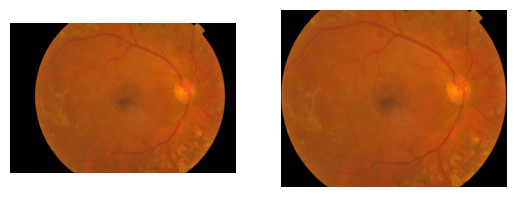

In [ ]:
path = '/content/train_images/001639a390f0.png'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img);
plt.subplot(1, 2, 2)
img_cropped = crop_image_from_gray(img)
plt.axis('off')
plt.imshow(img_cropped);

In [ ]:
def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted (image, 4, cv2.GaussianBlur(image, (0,0) ,10), -4, 128)
    return image

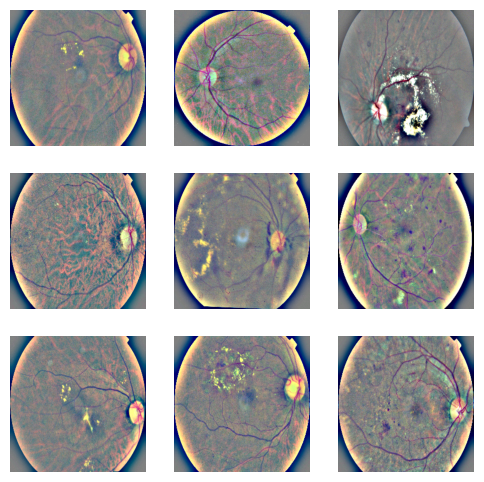

In [ ]:
plt.figure(figsize=(6,6))
for y,x in enumerate(x_train[:9]):
    plt.subplot(3, 3, y+1)
    plt.axis('off')
    i = preprocess(x)
    plt.imshow(i)

## **Loading**

In [ ]:
train_images = np.empty((len(x_train),IMG_SIZE,IMG_SIZE,3), dtype='uint8')
for i,path in enumerate(notebook.tqdm(x_train)):
    train_images[i] = preprocess(path)

  0%|          | 0/3112 [00:00<?, ?it/s]

In [ ]:
val_images = np.empty((len(x_val),IMG_SIZE,IMG_SIZE,3), dtype='uint8')
for i,path in enumerate(notebook.tqdm(x_val)):
    val_images[i] = preprocess(path)

  0%|          | 0/550 [00:00<?, ?it/s]